# Setup Inicial

In [1]:
#Python Default 

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

import pickle
import time
import random
import os
import inspect
import pathlib

#Essentials

import IPython
import numpy as np
from bs4 import BeautifulSoup
import requests
import func_timeout
import pandas as pd
from itables import show
from scipy.optimize import curve_fit

#from objproxies import *

import matplotlib.pyplot as plt

#Qiskit

import qiskit
from qiskit.circuit import Gate
from qiskit.circuit.library import *
from qiskit import transpile
from qiskit.providers.models import *
from qiskit_ibm_runtime.fake_provider import *
from qiskit.providers.fake_provider import *
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
from qiskit_aer import StatevectorSimulator
import qiskit_aer

## Qiskit Nature
    
from qiskit_nature.units import *   #ANGSTROM

from qiskit_nature.second_q.drivers import *    #PySCFDriver

from qiskit_nature.second_q.mappers import * #JordanWignerMapper

from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.problems import EigenstateResult

from qiskit_nature.second_q.circuit.library import *  #Ansatz, HF


## Qiskit Algorithms
    
from qiskit_algorithms.minimum_eigensolvers import VQE as  VQE_algorithms   #VQE
 
from qiskit_algorithms.optimizers import *    #SLSQP

from qiskit.circuit.library import EfficientSU2   #EfficientSU2

## Qiskit Estimators

from qiskit.primitives import Estimator as Estimator_Nature

from qiskit_aer.primitives.estimator import Estimator as Estimator_Aer

from qiskit_ibm_runtime import Estimator 

from qiskit_ibm_runtime import EstimatorV2

## Qiskit Noise Models

from qiskit_aer.noise import NoiseModel

from qiskit.providers.fake_provider import *

##Qiskit Runtime IBM

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options

## Braket

from braket.tracking import Tracker
from qiskit_braket_provider import *

## Mitiq 

from mitiq import zne


%matplotlib widget
#%matplotlib inline

In [22]:
# Backends

provider = BraketProvider()
local_simulator = BraketLocalBackend()
sv1 = provider.get_backend("SV1")
aria = provider.get_backend("Aria 1")
harmony = provider.get_backend("Harmony")
statevector_simulator = StatevectorSimulator()

# Setup inicial do problema

driver = PySCFDriver(
    atom= f"H 0 0 0; H 0 0 1",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

#estimator = Estimator(backend = local_simulator, options={"shots" : 2000, "noise_model" : noise_model, "coupling_map" : coupling_map})

estimator = Estimator(backend = local_simulator)

mapper = JordanWignerMapper()

ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

vqe_solver = VQE_algorithms(estimator, ansatz, COBYLA())

vqe_solver.initial_point = [0.0] * ansatz.num_parameters

calc = GroundStateEigensolver(mapper, vqe_solver)

minimum_eigenvalue = vqe_solver.compute_minimum_eigenvalue(calc.get_qubit_operators(es_problem)[0])

# Criando Circuito Aria - AWS

circuito = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), aria)

# Criando Circuito Brisbane - IBM

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

circuito_ibm = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), backend)

hamiltoniano = es_problem.second_q_ops()[0]

num_qubits_hamiltonian = JordanWignerMapper().map(hamiltoniano).num_qubits

new_circuit = QuantumCircuit(num_qubits_hamiltonian)

for gate in circuito_ibm.data:

    if all(circuito_ibm.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
        new_circuit.append(gate[0], [circuito_ibm.qubits.index(qubit) for qubit in gate[1]])

circuito_ibm = new_circuit

# Funções Globais

In [3]:
def get_current_directory():
    try:
        
        directory = os.path.dirname(os.path.abspath(__file__))

    except:
        
        ip = IPython.get_ipython()
        directory = None
        if '__vsc_ipynb_file__' in ip.user_ns:
            directory = os.path.dirname(ip.user_ns['__vsc_ipynb_file__'])
        
    return directory 


def salvar(a):
    
    script_dir = get_current_directory()
    
    dados_dir = os.path.join(script_dir, 'dados')
    
    os.makedirs(dados_dir, exist_ok=True)
    
    file_path = os.path.join(dados_dir, f'{a}.pickle')
    
    with open(file_path, 'wb') as f:
        pickle.dump(eval(a), f)

def abrir(a):
    
    script_dir = get_current_directory()
    
    file_path = os.path.join(script_dir, 'dados', f'{a}.pickle')
    
    with open(file_path, 'rb') as f:
        return pickle.load(f)

In [23]:

def run_statevector(circuit, driver, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   estado = Statevector.from_instruction(circuit)
   
   expectation_value = estado.expectation_value(mapper.map(hamiltoniano))
   
   return expectation_value.real

def run_estimator(circuit, driver, backend = None, shots = 2000, noise_model = None, coupling_map = None, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
   
   if noise_model is not None:
      
      estimator = Estimator(backend = backend, options = {"shots" : shots, "noise_model" : noise_model, "coupling_map" : coupling_map})
   
   else :
      
      estimator = Estimator(backend = backend, options = {"shots" : shots})
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

def run_estimator_aer(circuit, driver, shots = None, seed = None, mapper = JordanWignerMapper(), skip_transpilation = True):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit

   if shots != None:
   
      if seed is not None:
         
         estimator = Estimator_Aer(run_options = {"shots" : shots, "seed" : seed}, skip_transpilation = skip_transpilation)   
      
      else :
         
         estimator = Estimator_Aer(run_options = {"shots" : shots}, skip_transpilation = skip_transpilation)
   
   else :

      if seed is not None:
         
         estimator = Estimator_Aer(run_options = {"shots" : shots, "seed" : seed}, approximation = True, skip_transpilation = skip_transpilation)
      
      else :
         
         estimator = Estimator_Aer(run_options = {"shots" : shots}, approximation = True, skip_transpilation = skip_transpilation)
      
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

def run_estimator_aer_noise(circuit, driver, shots = None, seed = None, mapper = JordanWignerMapper(), skip_transpilation = True, noise_model = None, coupling_map = None, basis_gates = None):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
   
   estimator = Estimator_Aer(backend_options={'noise_model': noise_model}, run_options = {"shots" : shots, "seed" : seed}, skip_transpilation = skip_transpilation) if coupling_map == None and basis_gates == None else Estimator_Aer(backend_options={'noise_model': noise_model, 'coupling_map': coupling_map, 'basis_gates' : basis_gates}, run_options = {"shots" : shots, "seed" : seed}, skip_transpilation = skip_transpilation)
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

ESTIMATORS = {
    'statevector': run_statevector,
    'estimator': run_estimator,
    'estimator_aer': run_estimator_aer,
    'estimator_aer_noise': run_estimator_aer_noise,
}

def check(original_value, target, driver, difference_percentage, estimator_name='statevector', **kwargs):
    estimator_function = ESTIMATORS[estimator_name]
    target_value = estimator_function(target, driver, **kwargs)
    return abs(original_value - target_value) < difference_percentage * abs(original_value), target_value

# ZNE

In [5]:
def teste_circuit_folding(circuit, noise_factor):
  
    k = int((d := circuit.depth())*(noise_factor - 1)/2)
    
    n, s = k//d, k%d
      
    return n, s

def circuit_folding(circuit, noise_factor):
    
    k = int((d := circuit.depth())*(noise_factor - 1)/2)
    
    n, s = k//d, k%d
    
    
    circuito_original, circuito = circuit.copy(), circuit.copy()
    
    for a in range(n):
        
        inverse = circuito_original.inverse()
        
        identity = inverse.compose(circuito_original)
        
        circuito = circuito.compose(identity)
    
    if s != 0:
        
        circuito_parcial = QuantumCircuit(*circuito.qregs, *circuito.cregs)
                
        for instr in circuito.data[-s:]:
            
            circuito_parcial.append(instr[0], instr[1], instr[2])
    
        inverse = circuito_parcial.inverse()
        
        identity = inverse.compose(circuito_parcial)
        
        circuito = circuito.compose(identity)
    
    return circuito

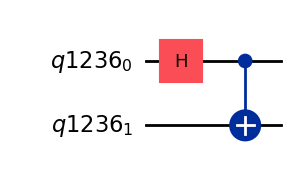

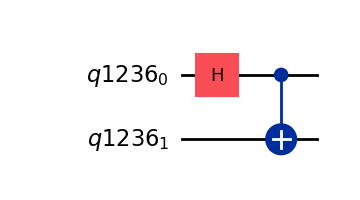

In [143]:
qubits = qiskit.QuantumRegister(2)
circuit_temp = qiskit.QuantumCircuit(qubits)
circuit_temp.h(0)
circuit_temp.cx(0, 1)

circuit_temp.draw('mpl')

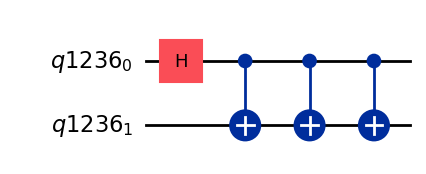

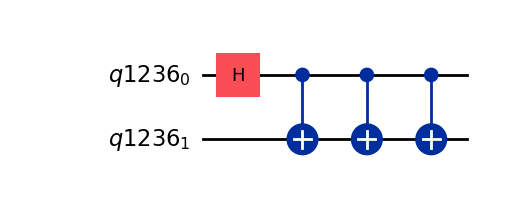

In [145]:
circuit_folding(circuit_temp, 2).draw("mpl")

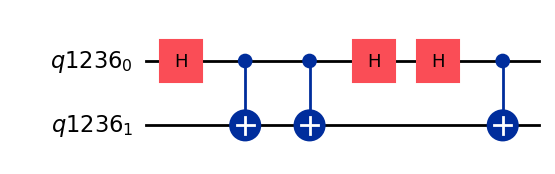

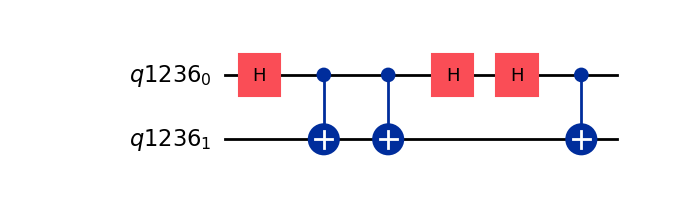

In [146]:
circuit_folding(circuit_temp, 3).draw("mpl")

In [124]:
def func(a):
    circuito_mitiq = zne.scaling.fold_global(circuit_temp, scale_factor=a)
    circuito_func = circuit_folding(circuit_temp, a)

    print(f"Lambda = {a}\n\nCircuito Mitiq :\n{circuito_mitiq}\n\nCircuito Função :\n{circuito_func}")

    print("--------------------------------")


for a in range(1, 10):
    func(a)

Lambda = 1

Circuito Mitiq :
         ┌───┐     
q1228_0: ┤ H ├──■──
         └───┘┌─┴─┐
q1228_1: ─────┤ X ├
              └───┘

Circuito Função :
         ┌───┐     
q1228_0: ┤ H ├──■──
         └───┘┌─┴─┐
q1228_1: ─────┤ X ├
              └───┘
--------------------------------
Lambda = 2

Circuito Mitiq :
         ┌───┐               
q1228_0: ┤ H ├──■────■────■──
         └───┘┌─┴─┐┌─┴─┐┌─┴─┐
q1228_1: ─────┤ X ├┤ X ├┤ X ├
              └───┘└───┘└───┘

Circuito Função :
         ┌───┐               
q1228_0: ┤ H ├──■────■────■──
         └───┘┌─┴─┐┌─┴─┐┌─┴─┐
q1228_1: ─────┤ X ├┤ X ├┤ X ├
              └───┘└───┘└───┘
--------------------------------
Lambda = 3

Circuito Mitiq :
         ┌───┐          ┌───┐┌───┐     
q1228_0: ┤ H ├──■────■──┤ H ├┤ H ├──■──
         └───┘┌─┴─┐┌─┴─┐└───┘└───┘┌─┴─┐
q1228_1: ─────┤ X ├┤ X ├──────────┤ X ├
              └───┘└───┘          └───┘

Circuito Função :
         ┌───┐          ┌───┐┌───┐     
q1228_0: ┤ H ├──■────■──┤ H ├┤ H ├──■──
         └

In [130]:
#arrumando a quantidade de qubits do circuito ibm:

new_circuit = QuantumCircuit(4)

for gate in circuito.data:

    if all(circuito.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
        new_circuit.append(gate[0], [circuito.qubits.index(qubit) for qubit in gate[1]])

circuito_pequeno = new_circuit

In [135]:
print(circuit_folding(circuito_pequeno, 7).depth())
print(circuito_pequeno.depth())

518
74


# Rodando o ZNE

In [ ]:
circuito_ibm.draw('mpl')

In [39]:
2/circuito.depth()

0.002770083102493075

In [10]:
depth_circuito = circuito.depth()

lambda_range = np.arange(1, 10, 2/depth_circuito)

circuitos = []

for a in lambda_range:
    
    print(f"Lambda = {a}\tn:{(temp := teste_circuit_folding(circuito, a))[0]}, s:{temp[1]}")
    
    circuitos.append(circuit_folding(circuito, a))

Lambda = 1.0	n:0, s:0
Lambda = 1.027027027027027	n:0, s:0
Lambda = 1.054054054054054	n:0, s:1
Lambda = 1.081081081081081	n:0, s:2
Lambda = 1.108108108108108	n:0, s:3
Lambda = 1.1351351351351349	n:0, s:4
Lambda = 1.1621621621621618	n:0, s:5
Lambda = 1.1891891891891888	n:0, s:6
Lambda = 1.2162162162162158	n:0, s:7
Lambda = 1.2432432432432428	n:0, s:8
Lambda = 1.2702702702702697	n:0, s:9
Lambda = 1.2972972972972967	n:0, s:10
Lambda = 1.3243243243243237	n:0, s:11
Lambda = 1.3513513513513506	n:0, s:12
Lambda = 1.3783783783783776	n:0, s:13
Lambda = 1.4054054054054046	n:0, s:14
Lambda = 1.4324324324324316	n:0, s:15
Lambda = 1.4594594594594585	n:0, s:16
Lambda = 1.4864864864864855	n:0, s:17
Lambda = 1.5135135135135125	n:0, s:18
Lambda = 1.5405405405405395	n:0, s:19
Lambda = 1.5675675675675664	n:0, s:20
Lambda = 1.5945945945945934	n:0, s:21
Lambda = 1.6216216216216204	n:0, s:22
Lambda = 1.6486486486486474	n:0, s:23
Lambda = 1.6756756756756743	n:0, s:24
Lambda = 1.7027027027027013	n:0, s:25
Lamb

In [11]:
expected_values = []

for circuito in circuitos:
    
    expected_values.append(run_estimator_aer_noise(circuito, es_problem, shots = 2000, noise_model = noise_model))

In [6]:
#salvar('expected_values')
depth_circuito = circuito.depth()
lambda_range = np.arange(1, 10, 2/depth_circuito)
expected_values = abrir('expected_values')

In [12]:
expected_values

[-1.5828428115953965,
 -1.5765316913229992,
 -1.5938987201540324,
 -1.5970351216824312,
 -1.582396219270729,
 -1.5807659163216587,
 -1.5820445568266819,
 -1.5948978014384192,
 -1.591413283939143,
 -1.5922622373689876,
 -1.58056908018507,
 -1.5885591275090398,
 -1.5907893223737795,
 -1.5866321352840136,
 -1.5848526812631352,
 -1.5906237757561654,
 -1.5858840822060591,
 -1.584221826797374,
 -1.600124031076092,
 -1.589320858251316,
 -1.5875924833177777,
 -1.5817982022690513,
 -1.5886206255725699,
 -1.590816867687221,
 -1.5829578845509835,
 -1.5848569731514746,
 -1.5802097641195036,
 -1.5885942320547157,
 -1.594748213031437,
 -1.5783544287404139,
 -1.5881939478119909,
 -1.5898910418105632,
 -1.586719910953922,
 -1.5909226424109146,
 -1.588989333606191,
 -1.5927940950252544,
 -1.5887968983371377,
 -1.5823345450640767,
 -1.585446619491162,
 -1.5868362838737797,
 -1.5900474360079657,
 -1.5795839491400447,
 -1.5900774195731358,
 -1.5875277165415935,
 -1.577922012558954,
 -1.5876864006650429,
 

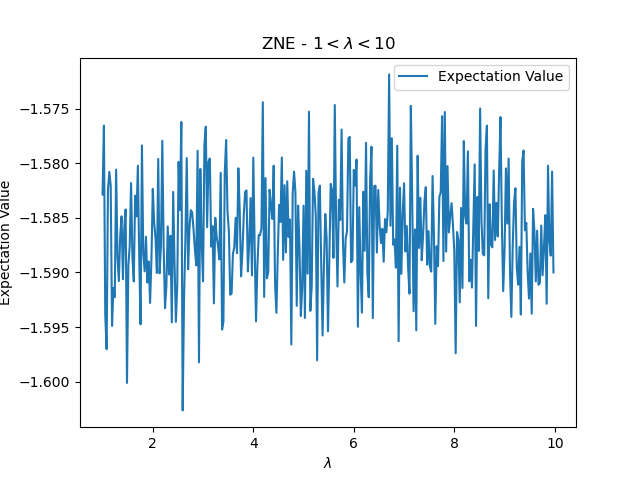

In [13]:
plt.figure()

plt.plot(lambda_range, expected_values, label = 'Expectation Value')

plt.xlabel(r'$\lambda$')
plt.ylabel('Expectation Value')
plt.title(r'ZNE - $1 < \lambda < 10$')
plt.legend()
plt.show()

In [26]:
expected_values_2 = []

for circuito in circuitos:
    
    expected_values_2.append(run_estimator_aer_noise(circuito, es_problem, shots = 2000, noise_model = noise_model, coupling_map=coupling_map, basis_gates = basis_gates))

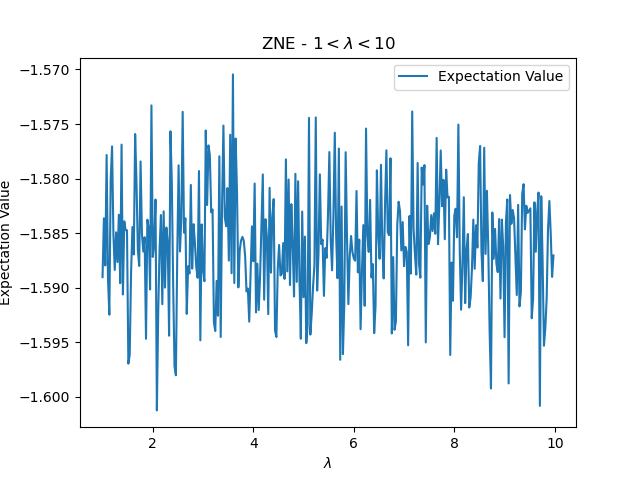

In [27]:
plt.figure()

plt.plot(lambda_range, expected_values_2, label = 'Expectation Value')

plt.xlabel(r'$\lambda$')
plt.ylabel('Expectation Value')
plt.title(r'ZNE - $1 < \lambda < 10$')
plt.legend()
plt.show()

In [30]:
depth_circuito = circuito_ibm.depth()

lambda_range = np.arange(1, 10, 2/depth_circuito)

circuitos_ibm = []

for a in lambda_range:
    
    print(f"Lambda = {a}\tn:{(temp := teste_circuit_folding(circuito, a))[0]}, s:{temp[1]}")
    
    circuitos_ibm.append(circuit_folding(circuito, a))

Lambda = 1.0	n:0, s:0
Lambda = 1.013986013986014	n:0, s:5
Lambda = 1.027972027972028	n:0, s:10
Lambda = 1.0419580419580419	n:0, s:15
Lambda = 1.0559440559440558	n:0, s:20
Lambda = 1.0699300699300698	n:0, s:25
Lambda = 1.0839160839160837	n:0, s:30
Lambda = 1.0979020979020977	n:0, s:35
Lambda = 1.1118881118881117	n:0, s:40
Lambda = 1.1258741258741256	n:0, s:45
Lambda = 1.1398601398601396	n:0, s:50
Lambda = 1.1538461538461535	n:0, s:55
Lambda = 1.1678321678321675	n:0, s:60
Lambda = 1.1818181818181814	n:0, s:65
Lambda = 1.1958041958041954	n:0, s:70
Lambda = 1.2097902097902093	n:0, s:75
Lambda = 1.2237762237762233	n:0, s:80
Lambda = 1.2377622377622373	n:0, s:85
Lambda = 1.2517482517482512	n:0, s:90
Lambda = 1.2657342657342652	n:0, s:95
Lambda = 1.2797202797202791	n:0, s:100
Lambda = 1.293706293706293	n:0, s:106
Lambda = 1.307692307692307	n:0, s:111
Lambda = 1.321678321678321	n:0, s:116
Lambda = 1.335664335664335	n:0, s:121
Lambda = 1.349650349650349	n:0, s:126
Lambda = 1.3636363636363629	n:

In [35]:
expected_values_ibm = []

for circuito in circuitos_ibm:
    
    expected_values_ibm.append(run_estimator_aer_noise(circuito, es_problem, shots = 2000, noise_model = noise_model, coupling_map=coupling_map, basis_gates = basis_gates))

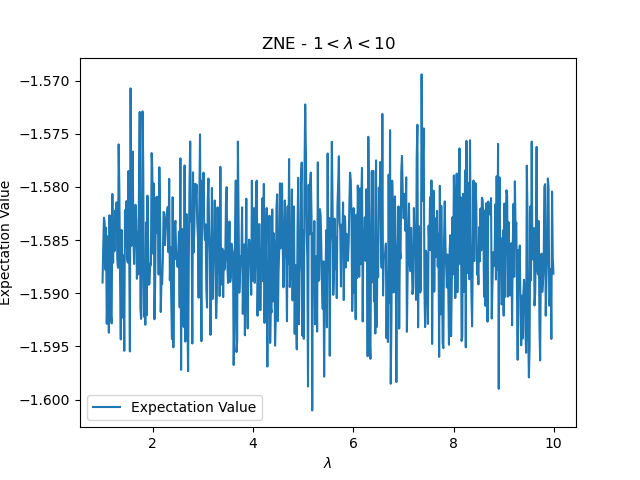

In [36]:
plt.figure()

plt.plot(lambda_range, expected_values_ibm, label = 'Expectation Value')

plt.xlabel(r'$\lambda$')
plt.ylabel('Expectation Value')
plt.title(r'ZNE - $1 < \lambda < 10$')
plt.legend()
plt.show()

In [ ]:
import qiskit_aer.noise as noise
from qiskit_aer import AerSimulator

backend = AerSimulator(noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates)

circuito_ibm_aer = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), backend)

hamiltoniano = es_problem.second_q_ops()[0]

num_qubits_hamiltonian = JordanWignerMapper().map(hamiltoniano).num_qubits

new_circuit = QuantumCircuit(num_qubits_hamiltonian)

for gate in circuito_ibm.data:

    if all(circuito_ibm.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
        new_circuit.append(gate[0], [circuito_ibm.qubits.index(qubit) for qubit in gate[1]])

circuito_ibm_aer = new_circuit

circuito_ibm_aer.draw('mpl')

In [46]:
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

depth_circuito = circuito_ibm_aer.depth()

lambda_range = np.arange(1, 3, 2/depth_circuito)

circuitos_ibm_aer = []

for a in lambda_range:
    
    print(f"Lambda = {a}\tn:{(temp := teste_circuit_folding(circuito, a))[0]}, s:{temp[1]}")
    
    circuitos_ibm_aer.append(circuit_folding(circuito, a))
    
expected_values_ibm_aer = []

for circuito in circuitos_ibm_aer:
    
    expected_values_ibm_aer.append(run_estimator_aer_noise(circuito, es_problem, shots = 2000, noise_model = noise_model, coupling_map=coupling_map, basis_gates = basis_gates))

Lambda = 1.0	n:0, s:0
Lambda = 1.013986013986014	n:0, s:49
Lambda = 1.027972027972028	n:0, s:98
Lambda = 1.0419580419580419	n:0, s:147
Lambda = 1.0559440559440558	n:0, s:197
Lambda = 1.0699300699300698	n:0, s:246
Lambda = 1.0839160839160837	n:0, s:295
Lambda = 1.0979020979020977	n:0, s:344
Lambda = 1.1118881118881117	n:0, s:394
Lambda = 1.1258741258741256	n:0, s:443
Lambda = 1.1398601398601396	n:0, s:492
Lambda = 1.1538461538461535	n:0, s:541
Lambda = 1.1678321678321675	n:0, s:591
Lambda = 1.1818181818181814	n:0, s:640
Lambda = 1.1958041958041954	n:0, s:689
Lambda = 1.2097902097902093	n:0, s:739
Lambda = 1.2237762237762233	n:0, s:788
Lambda = 1.2377622377622373	n:0, s:837
Lambda = 1.2517482517482512	n:0, s:886
Lambda = 1.2657342657342652	n:0, s:936
Lambda = 1.2797202797202791	n:0, s:985
Lambda = 1.293706293706293	n:0, s:1034
Lambda = 1.307692307692307	n:0, s:1083
Lambda = 1.321678321678321	n:0, s:1133
Lambda = 1.335664335664335	n:0, s:1182
Lambda = 1.349650349650349	n:0, s:1231
Lambda 

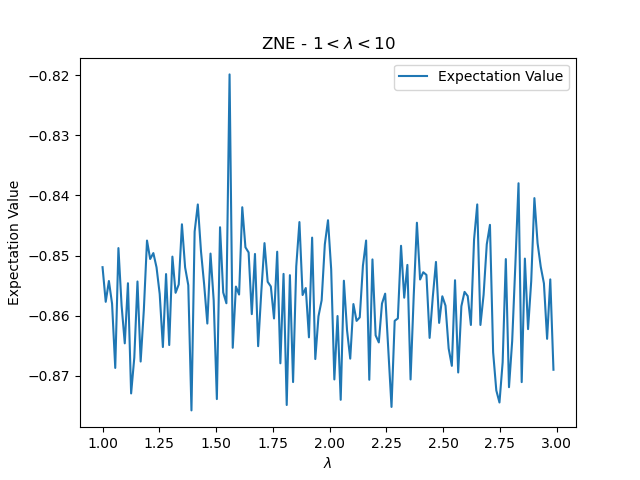

In [47]:
plt.figure()

plt.plot(lambda_range, expected_values_ibm_aer, label = 'Expectation Value')

plt.xlabel(r'$\lambda$')
plt.ylabel('Expectation Value')
plt.title(r'ZNE - $1 < \lambda < 10$')
plt.legend()
plt.show()

In [48]:
circuitos_ibm_aer = []

for a in lambda_range:
    
    print(f"Lambda = {a}\tn:{(temp := teste_circuit_folding(circuito, a))[0]}, s:{temp[1]}")
    
    circuitos_ibm_aer.append(circuit_folding(circuito, a))
    
expected_values_ibm_aer = []

for circuito in circuitos_ibm_aer:
    
    expected_values_ibm_aer.append(run_estimator_aer_noise(circuito, es_problem, shots = 2000, seed = 42, noise_model = noise_model, coupling_map=coupling_map, basis_gates = basis_gates))

Lambda = 1.0	n:0, s:0
Lambda = 1.013986013986014	n:0, s:121
Lambda = 1.027972027972028	n:0, s:242
Lambda = 1.0419580419580419	n:0, s:363
Lambda = 1.0559440559440558	n:0, s:485
Lambda = 1.0699300699300698	n:0, s:606
Lambda = 1.0839160839160837	n:0, s:727
Lambda = 1.0979020979020977	n:0, s:849
Lambda = 1.1118881118881117	n:0, s:970
Lambda = 1.1258741258741256	n:0, s:1091
Lambda = 1.1398601398601396	n:0, s:1212
Lambda = 1.1538461538461535	n:0, s:1334
Lambda = 1.1678321678321675	n:0, s:1455
Lambda = 1.1818181818181814	n:0, s:1576
Lambda = 1.1958041958041954	n:0, s:1698
Lambda = 1.2097902097902093	n:0, s:1819
Lambda = 1.2237762237762233	n:0, s:1940
Lambda = 1.2377622377622373	n:0, s:2061
Lambda = 1.2517482517482512	n:0, s:2183
Lambda = 1.2657342657342652	n:0, s:2304
Lambda = 1.2797202797202791	n:0, s:2425
Lambda = 1.293706293706293	n:0, s:2547
Lambda = 1.307692307692307	n:0, s:2668
Lambda = 1.321678321678321	n:0, s:2789
Lambda = 1.335664335664335	n:0, s:2910
Lambda = 1.349650349650349	n:0, 

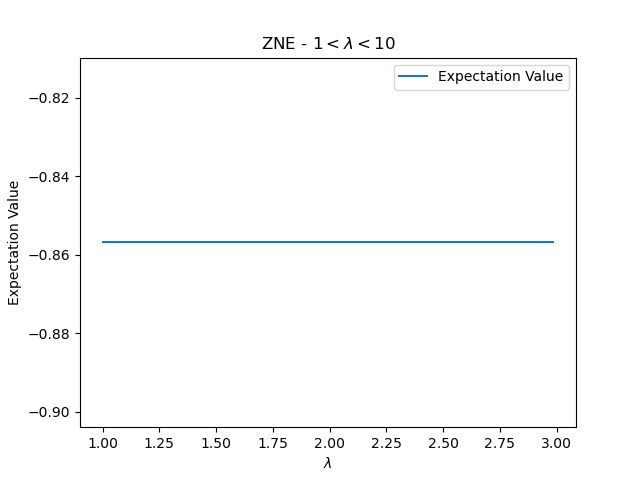

In [49]:
plt.figure()

plt.plot(lambda_range, expected_values_ibm_aer, label = 'Expectation Value')

plt.xlabel(r'$\lambda$')
plt.ylabel('Expectation Value')
plt.title(r'ZNE - $1 < \lambda < 10$')
plt.legend()
plt.show()

In [51]:
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

noise_model = NoiseModel()
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ['id', 'rz', 'sx', 'u1', 'u2', 'u3'])

circuitos_ibm_aer = []

for a in lambda_range:
    
    print(f"Lambda = {a}\tn:{(temp := teste_circuit_folding(circuito, a))[0]}, s:{temp[1]}")
    
    circuitos_ibm_aer.append(circuit_folding(circuito, a))
    
expected_values_ibm_aer = []

for circuito in circuitos_ibm_aer:
    
    expected_values_ibm_aer.append(run_estimator_aer_noise(circuito, es_problem, shots = 2000, seed = 42, noise_model = noise_model, coupling_map=coupling_map, basis_gates = basis_gates))

Lambda = 1.0	n:0, s:0
Lambda = 1.013986013986014	n:0, s:298
Lambda = 1.027972027972028	n:0, s:597
Lambda = 1.0419580419580419	n:0, s:896
Lambda = 1.0559440559440558	n:0, s:1195
Lambda = 1.0699300699300698	n:0, s:1493
Lambda = 1.0839160839160837	n:0, s:1792
Lambda = 1.0979020979020977	n:0, s:2091
Lambda = 1.1118881118881117	n:0, s:2390
Lambda = 1.1258741258741256	n:0, s:2689
Lambda = 1.1398601398601396	n:0, s:2987
Lambda = 1.1538461538461535	n:0, s:3286
Lambda = 1.1678321678321675	n:0, s:3585
Lambda = 1.1818181818181814	n:0, s:3884
Lambda = 1.1958041958041954	n:0, s:4182
Lambda = 1.2097902097902093	n:0, s:4481
Lambda = 1.2237762237762233	n:0, s:4780
Lambda = 1.2377622377622373	n:0, s:5079
Lambda = 1.2517482517482512	n:0, s:5378
Lambda = 1.2657342657342652	n:0, s:5676
Lambda = 1.2797202797202791	n:0, s:5975
Lambda = 1.293706293706293	n:0, s:6274
Lambda = 1.307692307692307	n:0, s:6573
Lambda = 1.321678321678321	n:0, s:6872
Lambda = 1.335664335664335	n:0, s:7170
Lambda = 1.349650349650349	

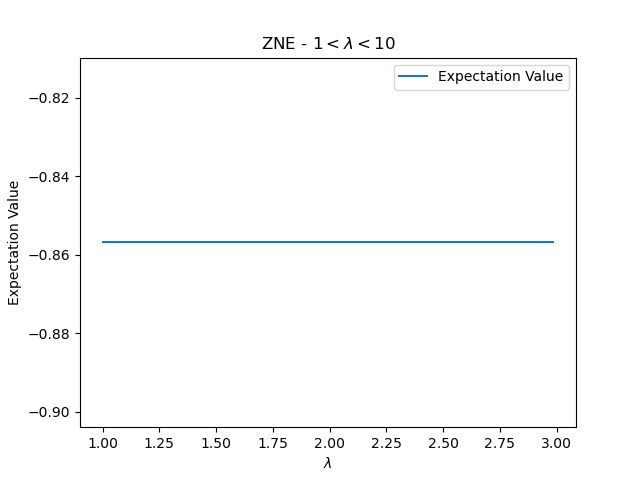

In [52]:
plt.figure()

plt.plot(lambda_range, expected_values_ibm_aer, label = 'Expectation Value')

plt.xlabel(r'$\lambda$')
plt.ylabel('Expectation Value')
plt.title(r'ZNE - $1 < \lambda < 10$')
plt.legend()
plt.show()